# Kaggle Titanic survival - checking model calibration

As well as classifying a case into a specific class (e.g. survived or died), it may be useful to look at the probability that the model assigns to a case being a specific class. Examples of when probability may be important include:

* High risk models (e.g. medical) – to be clear on risk being taken
* When probability thresholds are important to decision-making (e.g. screening when a relatively low probability may still signify further action should be taken).
* Improving our models - focussing on mistakes with v.high or v.low probabilities.

When we are interested in probabilities, it is important to be able to trust the probabilities reported by the model. This involves two steps:

1. Check whether model probabilities are well calibrated
2. If necessary re-calibrate the model

In this work book we will look at checking model calibration. We will first perform a single run working through the steps 'manually', and then put it in to a stratified k-fold loop using sklearn's `calibration_curve` method.

When checking probability calibration it is important, just like when check accuracy, that we test calibration on a test set that has not been used to train the model. Like checking accuracy, we can also use stratified k-fold validation to get a more accurate assessment of calibration (which we will use when we use sklearn's built-in methods).

If you are unfamiliar with stratfied k-fold validation for replication of machine learning testing, please see:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

## Load modules

In [1]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = False

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv')

Once downloaded, load data and remove passenger index number.

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

### Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [5]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Single run method

Here we will go through the steps of calibration to illustrate how it is performed. We will then put this code inside a stratified k-fold loop below.

### Divide into training and calibration test sets

We will divide the data in training and calibration test sets (75:25 split).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Fit Random Forest model

In [7]:
# Set up and fit model
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Predict probabilities for calibration

Now we can use the trained model to predict the probability of survival using the model's `predict_proba` method.

In [8]:
y_calibrate_probabilities = model.predict_proba(X_test)[:,1]

### Reliablity plot

In the reliability plot we will bin cases by their predicted probability, into 10 bins of probability of surviving.

In [9]:
# Bin data with numpy digitize (this will assign a bin to each case)
step = 0.10
bins = np.arange(step, 1+step, step)
digitized = np.digitize(y_calibrate_probabilities, bins)

# Put data in DataFrame
reliability = pd.DataFrame()
reliability['bin'] = digitized
reliability['probability'] = y_calibrate_probabilities
reliability['observed'] = y_test.values

# Summarise data by bin in new dataframe
reliability_summary = pd.DataFrame()

# Add bins to summary
reliability_summary['bin'] = bins

# Calculate mean of predicted probability of survival for each bin
reliability_summary['confidence'] = \
    reliability.groupby('bin').mean()['probability']

# Calculate the proportion of passengers who survive in each bin
reliability_summary['fraction_positive'] = \
    reliability.groupby('bin').mean()['observed']

In [10]:
reliability_summary

,bin,confidence,fraction_positive
0,0.1,0.043559,0.101695
1,0.2,0.146923,0.038462
2,0.3,0.251481,0.074074
3,0.4,0.340526,0.421053
4,0.5,0.429167,0.333333
5,0.6,0.542857,0.642857
6,0.7,0.652500,0.833333
7,0.8,0.745833,0.916667
8,0.9,0.857333,1.000000
9,1.0,0.924667,0.933333


Plot results:

In a perfectly calibrated model, the fraction of passengers who survive should be the same as the average probability of survival in each bin.

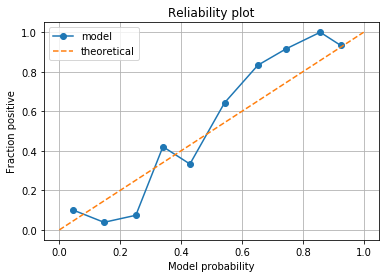

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reliability_summary['confidence'], 
         reliability_summary['fraction_positive'],
         linestyle='-',
         marker='o',
         label='model')

plt.plot([0,1],[0,1],
         linestyle='--',
         label='theoretical')

plt.xlabel('Model probability')
plt.ylabel('Fraction positive')

plt.title('Reliability plot')

plt.grid()
plt.legend()
plt.show()

What to look for in a Reliability Plot:

* Run the plot multiple times - is there a consistent pattern? See below for code using sklearn methods that allows for easy replication of reliability plots.
* Points below the diagonal: The model has over-forecast - the calculated probabilities are too large.
* Points above the diagonal: The model has under-forecast - the calculated probabilities are too small.


## Using stratfied k-fold validation and sklearn's calibration curve method

The method below will take the output probabilities from the Random Forest model and use sklearn's `calibration_curve` method to create bins of model probability and the fraction positive in each bin. We will use 'quantile' binning which creates bins of equal size. Use of uniform bins (bins of uniform width) can cause problems if a bin is empty.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Convert data to NumPy arrays (required for stratified k-fold)
X_np = X.values
y_np = y.values

# Set up k-fold splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, 
                      random_state=42)
skf.get_n_splits(X_np, y_np)

# Define bins
number_of_bins = 10

# Set up results DataFrames (to get results from each run)
results_model_probability = pd.DataFrame()
results_fraction_positive = pd.DataFrame()

# Loop through the k-fold splits
loop_counter = 0
for train_index, test_index in skf.split(X_np, y_np):    
        
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Set up and fit model
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    
    # Get test set proabilities
    y_calibrate_probabilities = model.predict_proba(X_test)[:,1]
    
    # Get calibration curve (use quantile to make sure all bins exist)
    fraction_pos, model_prob = calibration_curve(
        y_test, y_calibrate_probabilities, 
        n_bins=number_of_bins,
        strategy='quantile')    

    # record run results
    results_model_probability[loop_counter] = model_prob
    results_fraction_positive[loop_counter] = fraction_pos
    
    # Increment loop counter
    loop_counter += 1

### Plot results

Plot individual runs and means for bins.

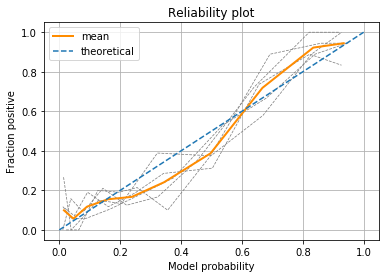

In [13]:
%matplotlib inline

# Add individual k-fold runs
for run in range(number_of_splits):
    plt.plot(results_model_probability[run],
             results_fraction_positive[run],
             linestyle='--',
             linewidth=0.75,
             color='0.5')
    
# Add mean
plt.plot(results_model_probability.mean(axis=1),
         results_fraction_positive.mean(axis=1),
         linestyle='-',
         linewidth=2,
         color='darkorange',
         label='mean')

# Add diagonal
plt.plot([0,1],[0,1],
         linestyle='--',
         label='theoretical')

plt.xlabel('Model probability')
plt.ylabel('Fraction positive')

plt.title('Reliability plot')

plt.grid()
plt.legend()
plt.show()

### Observations

* Using k-fold splits and taking the mean we can see our model probability is reasonably well calibrated.
* Testing the model calibration gives us confidence that the probabilities reported by the model are reasonable.

## What do do if a model is poorly calibrated

If a model is poorly calibrated (if the calibration curve is significantly offset from the diagonal) then the model may be recalibrated. The most common method of recalibration is to take the probability output of the calibration data set(s) and fit a logistic regression model using those outputs and the known `y` values (survived or not) for those probabilities. This is known as *Platt scaling*. Another method is known as isotonic scaling, but is prone to over-fitting, so is only suitable for large data sets.

Platt scaling may be easily implemented by adding in a logistic regression model fitted to the output of the calibration test. Platt scaling and isotonic scaling may also be performed by using the `CalibratedClassifier` method built in to sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html